## ARIMA model testing
So, we may have jumped the gun a little bit by going right for a full bootstrapped hyperparameter grid search here. The testing loop is working, but we are getting lots of warnings about failed convergence and similar. Also, we have a pretty big parameter space to explore given how slow the model fits. I also feel like I lack the familiarity with ARIMA models to do massive, parallel experiments in intelligent ways. So, for now, the plan is to step back and do some manual experimentation. The rough list of goals is as follows.
1. Build some intuition about ARIMA models, especially in relation to our data.
2. Find some initial conditions that are close to a 'good' solution to constrain the gridsearch somewhat.
3. Do some sanity checking to make a few decisions about how to set the bootstrapping loop up.
4. Convince ourselves that ARIMA models are even worth trying for this dataset in the first place.

The big issue here will be the fact that we have >3000 separate time courses, one for each county. Some might be well behave for ARIMA, while others not so much. We can't inspect each one, so we will have to pick a few at random to work with. 

First up, let's just make some quick diagnostic plots which have come up several times in my reading about ARIMA models.

In [1]:
import sys
sys.path.append('..')
import config as conf

paths = conf.DataFilePaths()
params = conf.ARIMA_model_parameters()

import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt

from itertools import product
from pandas.plotting import autocorrelation_plot

print(f'Statsmodels: {sm.__version__}')

Statsmodels: 0.13.2


In [2]:
# Load parsed data - note: 38 is the max block size because we lost
# the first row of each timecourse to differencing
block_size = 37
input_file = f'{paths.PARSED_DATA_PATH}/{params.input_file_root_name}{block_size}.npy'
timepoints = np.load(input_file)

print(f'Timepoints shape: {timepoints.shape}')
print()
print('Column types:')
print()

for column in timepoints[0,0,0,0:]:
    print(f'\t{type(column)}')

print()
print(f'Example block:')
print()

for row in timepoints[0,0,0:,:]:
    print('\t', end = '')
    for col in row:
        print(f'{col:.2E}', end=' ')

    print()

Timepoints shape: (1, 3135, 37, 6)

Column types:

	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>

Example block:

	1.00E+03 1.57E+18 2.88E+00 1.20E+03 1.00E+00 -1.23E-01 
	1.00E+03 1.57E+18 3.06E+00 1.27E+03 2.00E+00 1.71E-01 
	1.00E+03 1.57E+18 2.99E+00 1.24E+03 3.00E+00 -6.26E-02 
	1.00E+03 1.58E+18 2.99E+00 1.24E+03 4.00E+00 0.00E+00 
	1.00E+03 1.58E+18 2.97E+00 1.24E+03 5.00E+00 -2.41E-02 
	1.00E+03 1.58E+18 2.91E+00 1.22E+03 6.00E+00 -5.98E-02 
	1.00E+03 1.58E+18 2.93E+00 1.23E+03 7.00E+00 2.39E-02 
	1.00E+03 1.59E+18 3.00E+00 1.26E+03 8.00E+00 6.69E-02 
	1.00E+03 1.59E+18 3.00E+00 1.26E+03 9.00E+00 4.78E-03 
	1.00E+03 1.59E+18 3.02E+00 1.26E+03 1.00E+01 1.43E-02 
	1.00E+03 1.59E+18 3.08E+00 1.29E+03 1.10E+01 6.45E-02 
	1.00E+03 1.60E+18 3.17E+00 1.33E+03 1.20E+01 9.08E-02 
	1.00E+03 1.60E+18 3.21E+00 1.34E+03 1.30E+01 3.11E-02 
	1.00E+03 1.60E+18 3.19E+00 1.34E+03 1.40E+01 -1.2

In [3]:
plot_rows = 6
plot_cols = 4
x_values = list(range(timepoints.shape[2]))

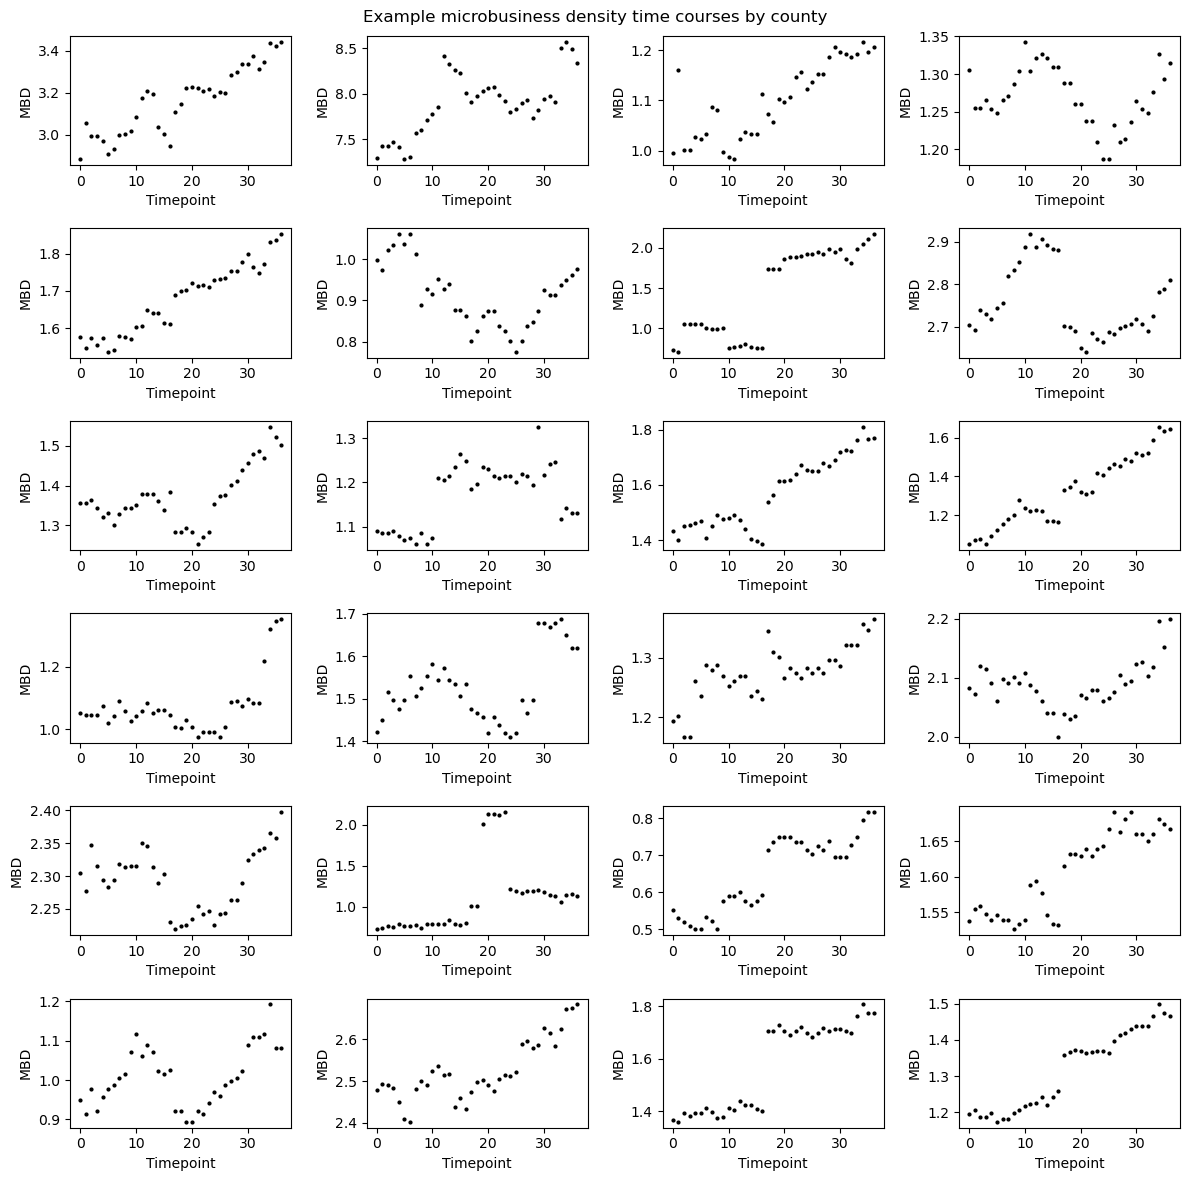

In [5]:
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        ax[i,j].scatter(
            x_values,
            timepoints[0,plot_num,:,2],
            color='black',
            s=4
        )
        
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Example microbusiness density time courses by county')
plt.tight_layout()

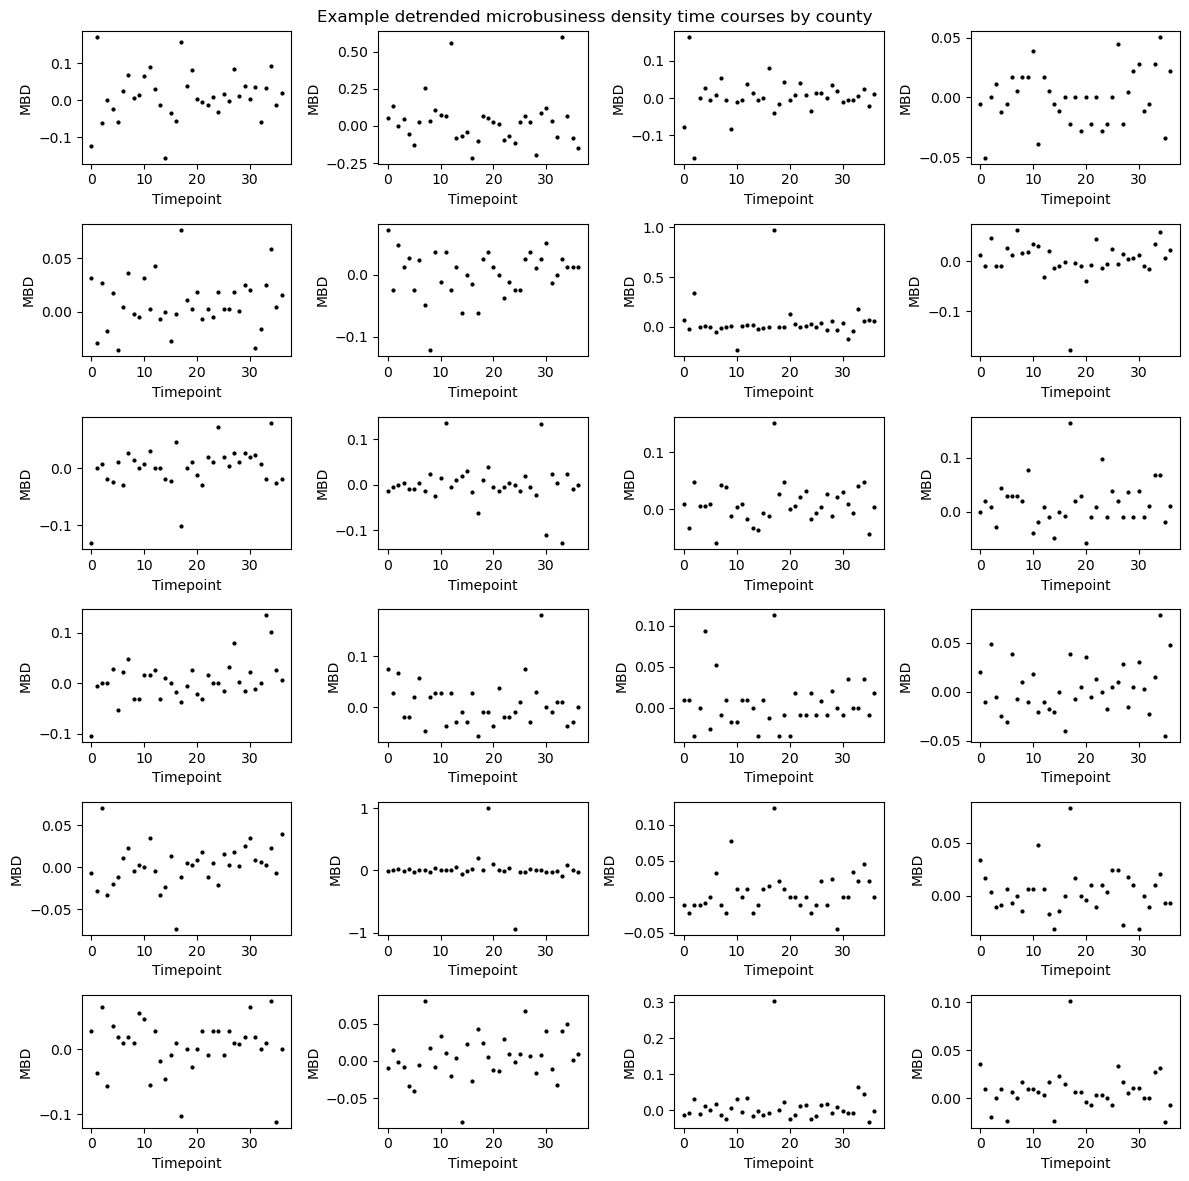

In [6]:
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        ax[i,j].scatter(
            x_values,
            timepoints[0,plot_num,:,5],
            color='black',
            s=4
        )
        
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Example detrended microbusiness density time courses by county')
plt.tight_layout()

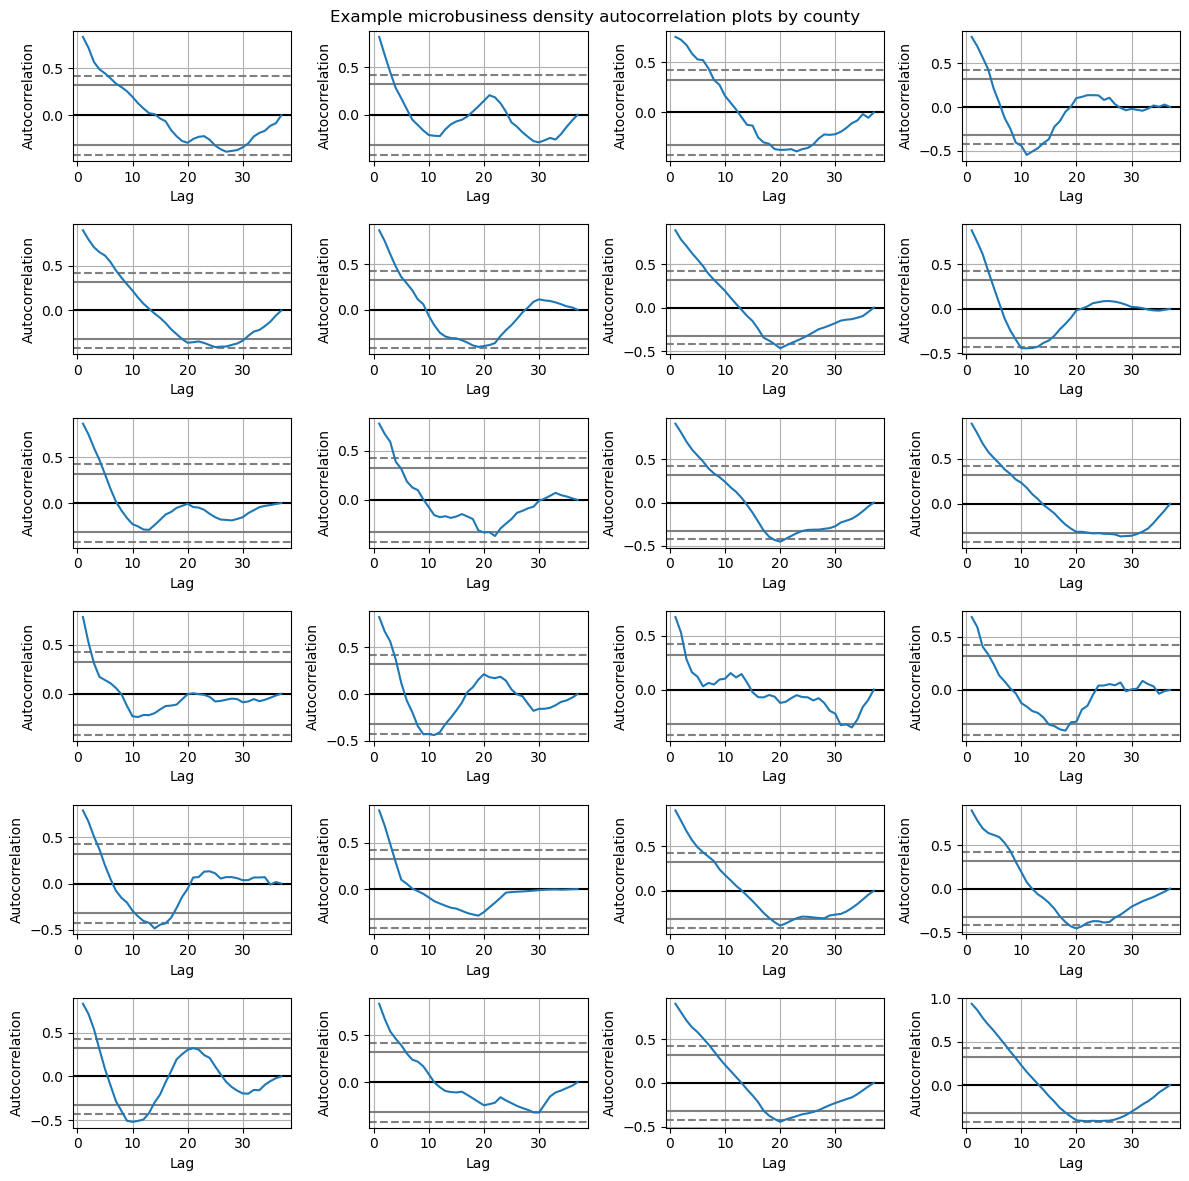

In [7]:
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        autocorrelation_plot(pd.Series(timepoints[0,plot_num,:,2]), ax=ax[i,j])

        plot_num += 1

plt.suptitle('Example microbusiness density autocorrelation plots by county')
plt.tight_layout()

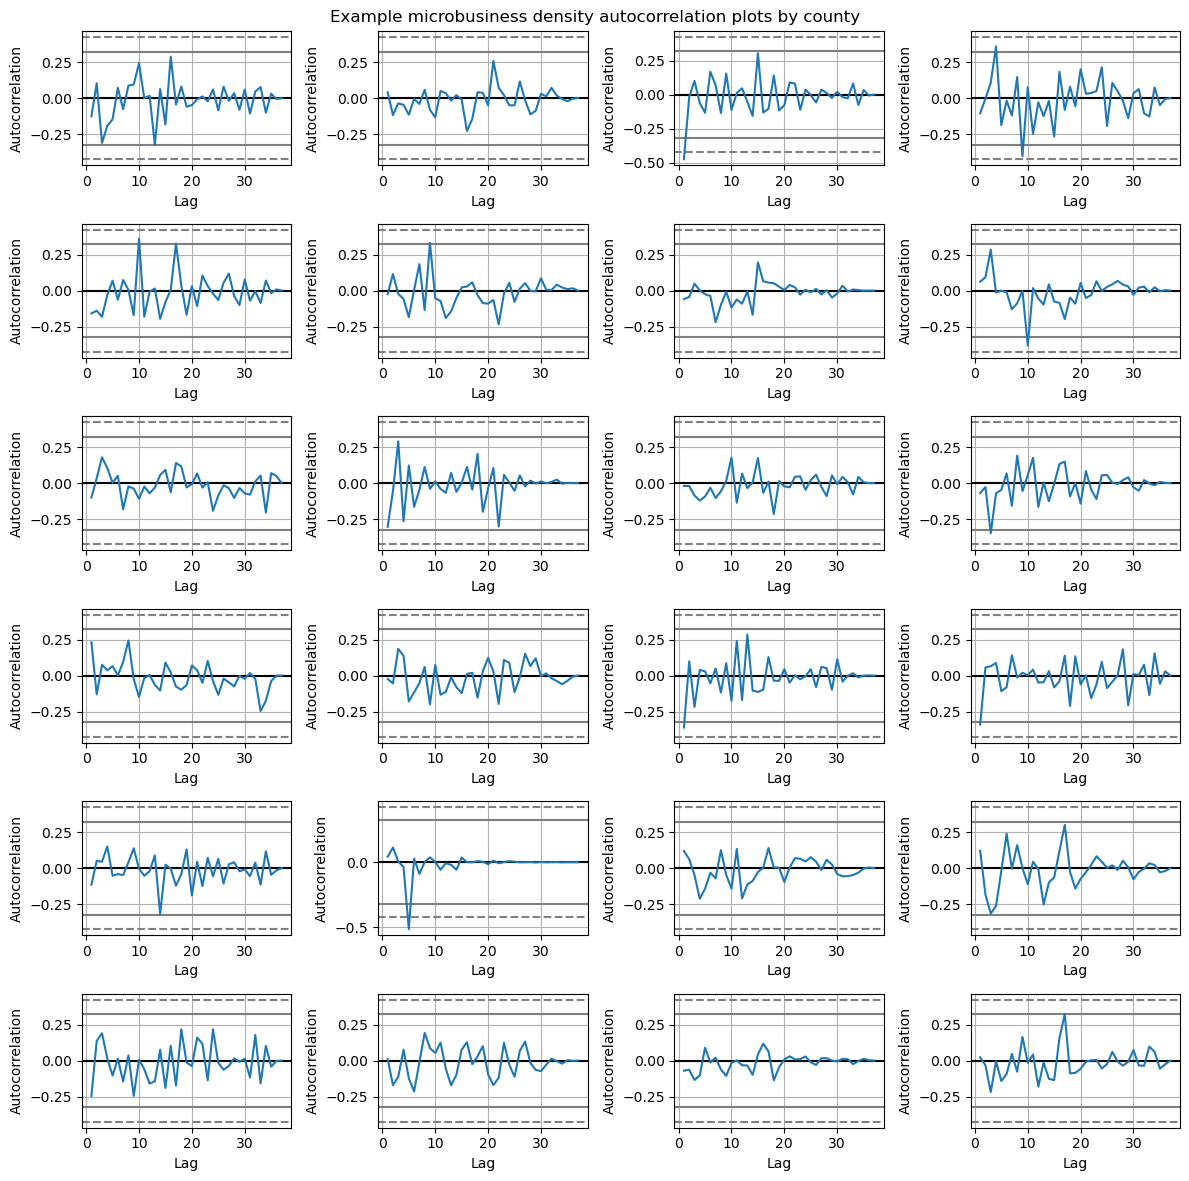

In [8]:
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        autocorrelation_plot(pd.Series(timepoints[0,plot_num,:,5]), ax=ax[i,j])

        plot_num += 1

plt.suptitle('Example microbusiness density autocorrelation plots by county')
plt.tight_layout()

OK, hard to draw any conclusions from manually inspecting such a small number of plots. 

But, we know from our unit root testing (see notebook #02.2) that we have a lot of non-stationary counties (and some other weird stuff) and this is supported by the plots above. The issues with non-stationarity are mostly alleviated by one differencing, at least according to unit root testing. So, let's use 1 for our model's differencing degree. 

From the autocorrelation plots we can see that raw MBD data tends to have good positive autocorrelation out to about 5 lags or so for most of the counties we looked at. After that it tends to dip negative in most cases. Will probably want to start with lag order around 5. After differencing, any consistent autocorrelation signature is pretty much gone. Let's fit an ARIMA model to a few of these counties and see what we get.

In [9]:
from statsmodels.tsa.arima.model import ARIMA

fitted_models = []

for i in range(plot_cols * plot_rows):
    model = ARIMA(pd.Series(timepoints[0,i,:,2]), order=(2,2,0), missing='raise')
    model_fit = model.fit()

    fitted_models.append(model_fit)

/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


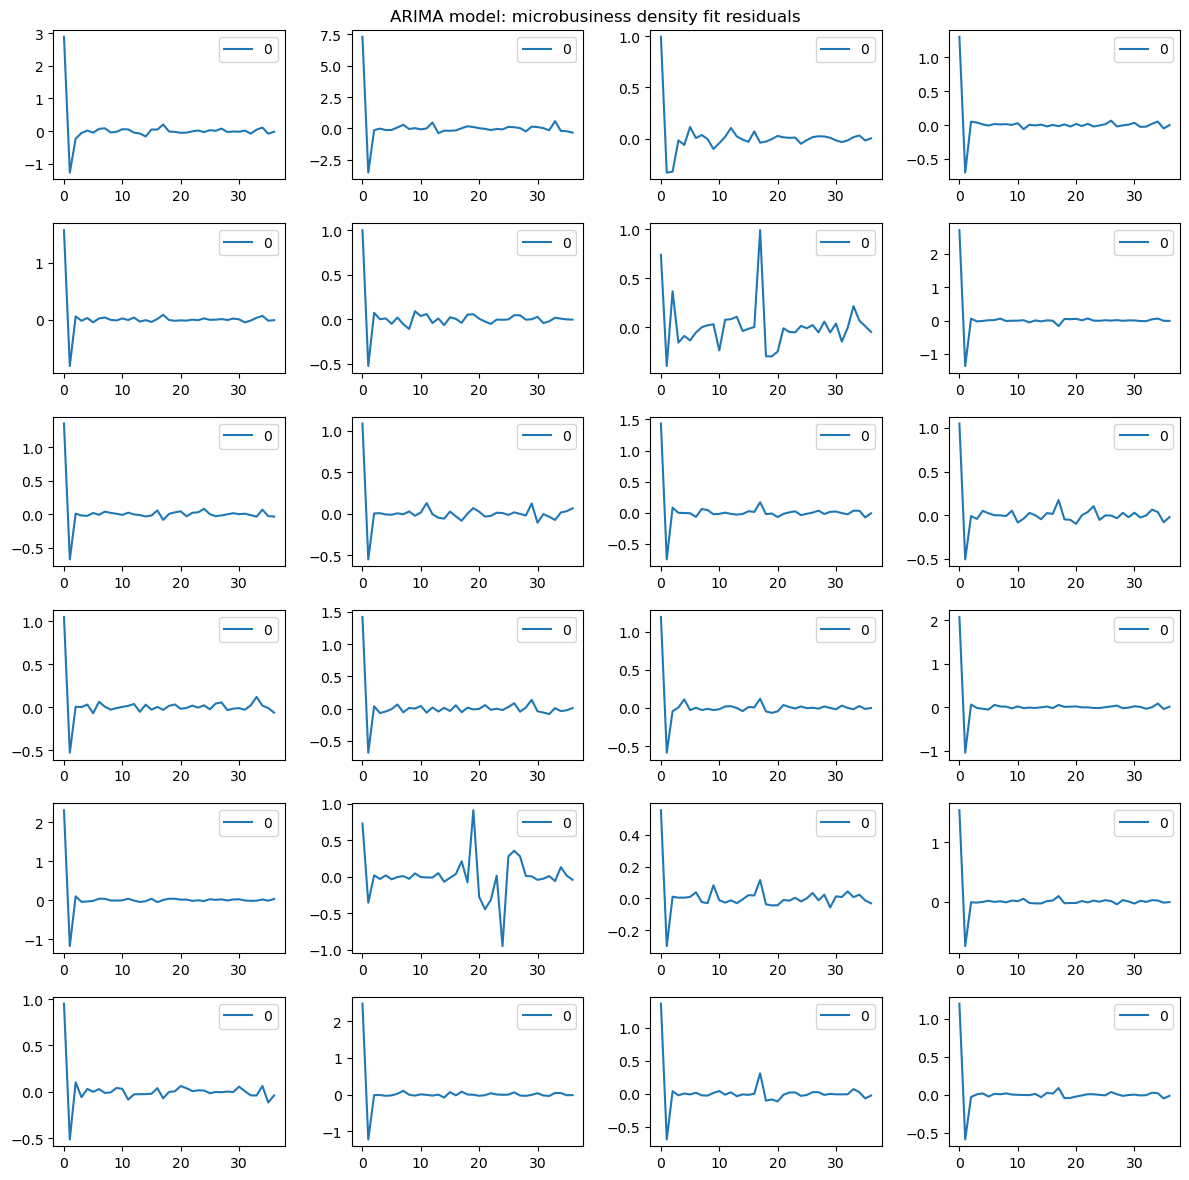

In [10]:
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        residuals = pd.DataFrame(fitted_models[plot_num].resid)
        residuals.plot(ax=ax[i,j])

        plot_num += 1

plt.suptitle('ARIMA model: microbusiness density fit residuals')
plt.tight_layout()

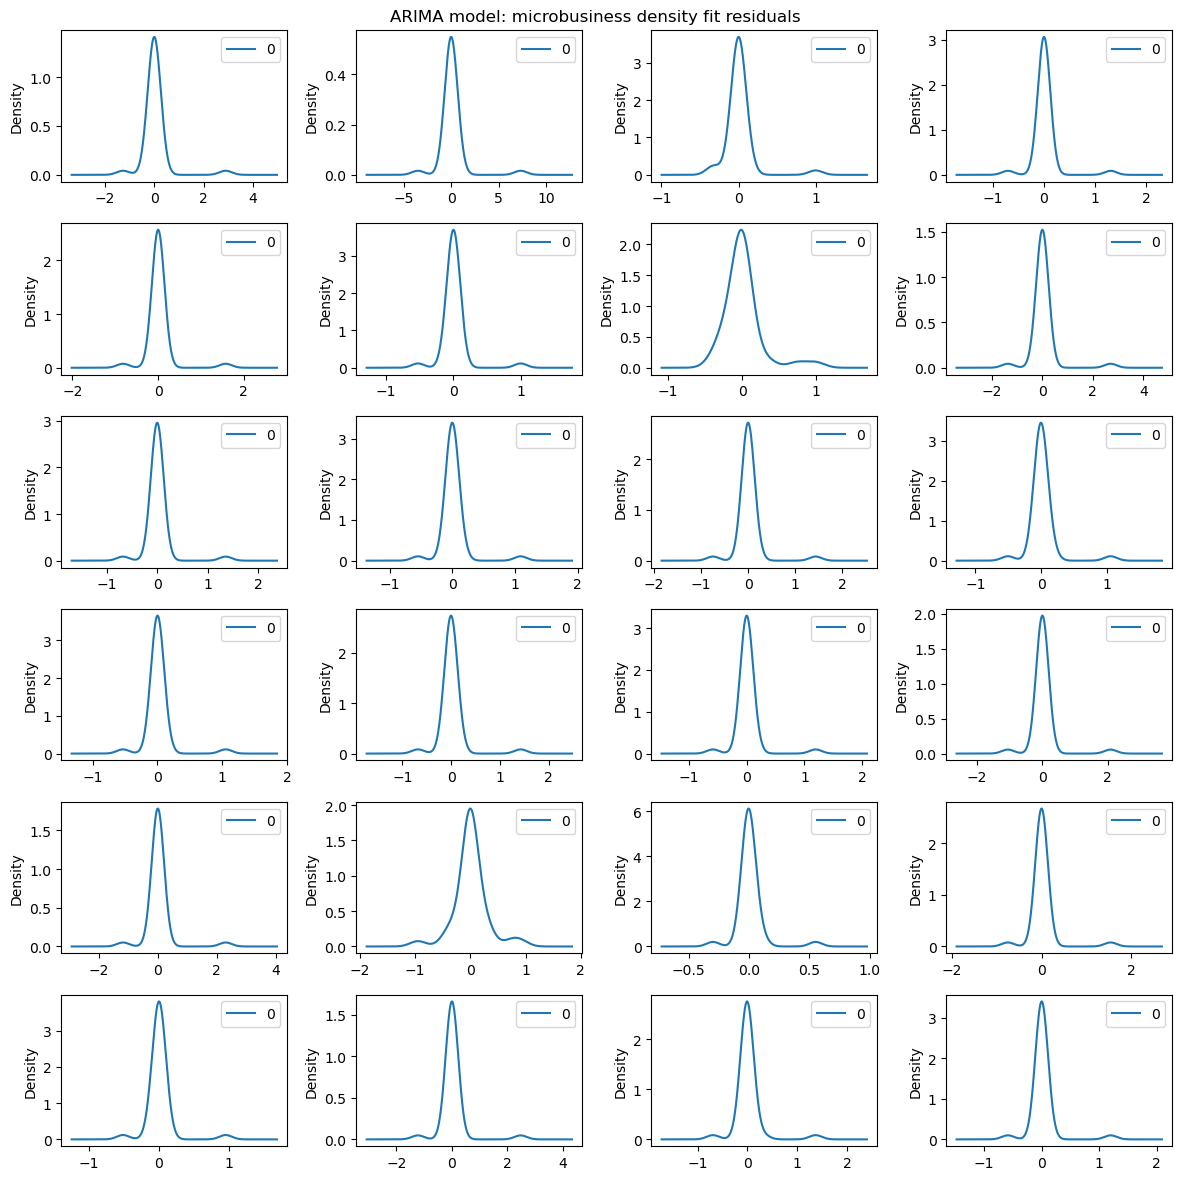

In [11]:
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        residuals = pd.DataFrame(fitted_models[plot_num].resid)
        residuals.plot(kind='kde', ax=ax[i,j])

        plot_num += 1

plt.suptitle('ARIMA model: microbusiness density fit residuals')
plt.tight_layout()

OK, strange - first observation. The fit residuals look mostly normal-ish about zero, but the all have a small bump at high values. Looking at the time series plots, it's apparent that this bump is coming from the first, or maybe the first few timepoints. Not sure why this would be. Chopping off an arbitrary few points from each timeseries and running the fits again gives the same result. The first timepoint in the series always has a high fit residual. In most cases very much higher than the rest of the datapoints.

I think I figured it out. It looks like when the difference degree is set to 1, the residual for the first point is always very high. Not sure why this is, or if there is some parameter I am not setting which is supposed to solve it, but for now, at least we know how to avoid it. Kind of annoying to have to manually difference the data rather than setting it when describing a ARIMA model, but OK.

Let's see if we can clean up some of the plots above and keep experimenting.

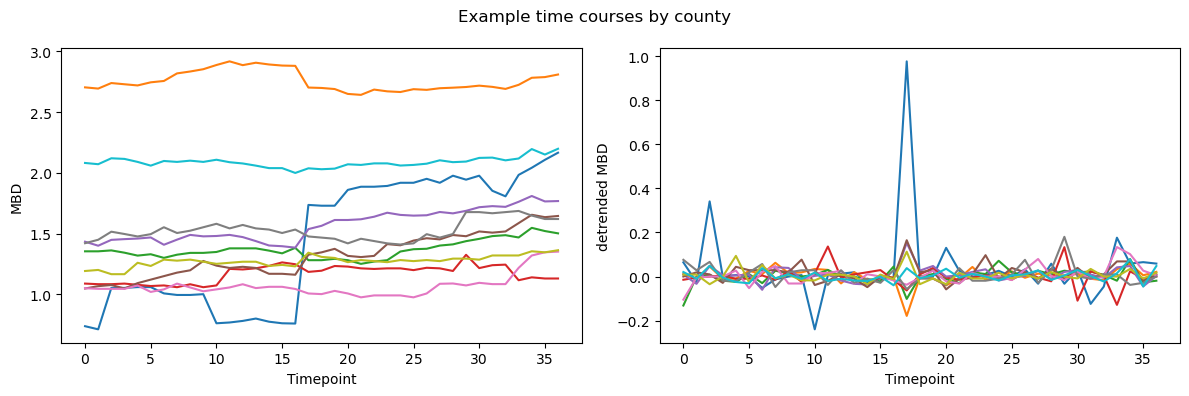

In [12]:
num_samples = 10

fig, ax = plt.subplots(1, 2, figsize=(12,4))

for i in range(num_samples):
        
    ax[0].plot(x_values, timepoints[0,i + 6,:,2])
    ax[0].set_xlabel(f'Timepoint')
    ax[0].set_ylabel(f'MBD')

for i in range(num_samples):
        
    ax[1].plot(x_values, timepoints[0,i + 6,:,5])
    ax[1].set_xlabel(f'Timepoint')
    ax[1].set_ylabel(f'detrended MBD')

plt.suptitle('Example time courses by county')
plt.tight_layout()

In [13]:
fitted_models = {
    'MBD ARIMA(2,0,0)': [],
    'MBD ARIMA(2,1,0)': [],
    'detrended MBD ARIMA(2,0,0)': [],
    'detrended MBD ARIMA(2,1,0)': []
}

for i in range(num_samples):
    model = ARIMA(pd.Series(timepoints[0,i + 6,:,2]), order=(2,0,0))
    model_fit = model.fit()
    fitted_models['MBD ARIMA(2,0,0)'].append(model_fit)

for i in range(num_samples):
    model = ARIMA(pd.Series(timepoints[0,i + 6,:,2]), order=(2,1,0))
    model_fit = model.fit()
    fitted_models['MBD ARIMA(2,1,0)'].append(model_fit)

for i in range(num_samples):
    model = ARIMA(pd.Series(timepoints[0,i + 6,:,5]), order=(2,0,0))
    model_fit = model.fit()
    fitted_models['detrended MBD ARIMA(2,0,0)'].append(model_fit)

for i in range(num_samples):
    model = ARIMA(pd.Series(timepoints[0,i + 6,:,5]), order=(2,1,0))
    model_fit = model.fit()
    fitted_models['detrended MBD ARIMA(2,1,0)'].append(model_fit)

/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
plot_rows = [0,1]
plot_cols = [0,1]
plot_dim = 3

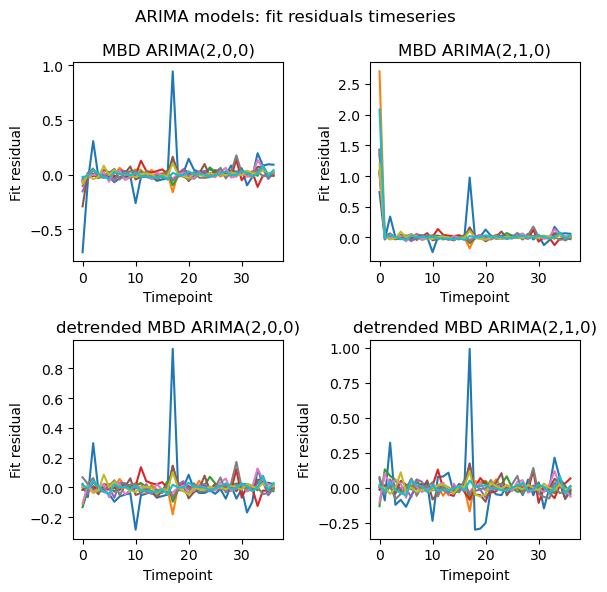

In [16]:
fig, ax = plt.subplots(len(plot_cols), len(plot_rows), figsize=(len(plot_rows) * plot_dim, len(plot_rows) * plot_dim))

for (model_string, fitted_model), subplot in zip(fitted_models.items(), product(plot_rows, plot_cols)):

    for i in range(num_samples):
        residuals = pd.DataFrame(fitted_models[model_string][i].resid)
        residuals.plot(legend=False, ax=ax[subplot])
        ax[subplot].set_xlabel(f'Timepoint')
        ax[subplot].set_ylabel(f'Fit residual')
        ax[subplot].set_title(model_string)

plt.suptitle('ARIMA models: fit residuals timeseries')
plt.tight_layout()

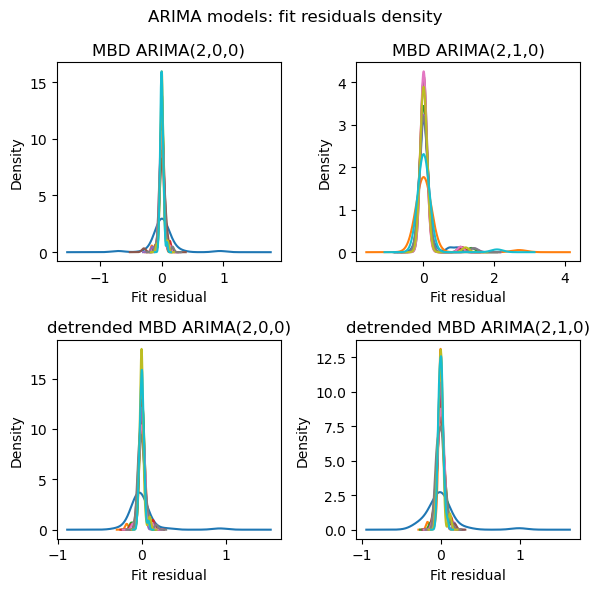

In [18]:
fig, ax = plt.subplots(len(plot_cols), len(plot_rows), figsize=(len(plot_rows) * plot_dim, len(plot_rows) * plot_dim))

for (model_string, fitted_model), subplot in zip(fitted_models.items(), product(plot_rows, plot_cols)):

    for i in range(num_samples):
        residuals = pd.DataFrame(fitted_models[model_string][i].resid)
        residuals.plot(kind='kde', legend=False, ax=ax[subplot])
        ax[subplot].set_xlabel(f'Fit residual')
        ax[subplot].set_ylabel(f'Density')
        ax[subplot].set_title(model_string)

plt.suptitle('ARIMA models: fit residuals density')
plt.tight_layout()

OK, preliminary conclusion - we should detrend our own data and set the difference degree to 0 in the model. It still bothers me a bit that using a non-zero difference degree seems to cause problems with the first input point. Seems like that should not be the case. But we have bigger fish to fry.

In [19]:
fitted_models = {
    'detrended MBD ARIMA(1,0,0)': [],
    'detrended MBD ARIMA(2,0,0)': [],
    'detrended MBD ARIMA(3,0,0)': [],
    'detrended MBD ARIMA(4,0,0)': [],
    'detrended MBD ARIMA(5,0,0)': [],
    'detrended MBD ARIMA(6,0,0)': []
}

lag_order = 0

for model_string in fitted_models.keys():
    for i in range(num_samples):
        model = ARIMA(pd.Series(timepoints[0,i,:,5]), order=(lag_order,0,0))
        model_fit = model.fit()
        fitted_models[model_string].append(model_fit)

    lag_order += 1

/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

In [26]:
plot_rows = [0,1]
plot_cols = [0,1,2]
plot_dim = 3

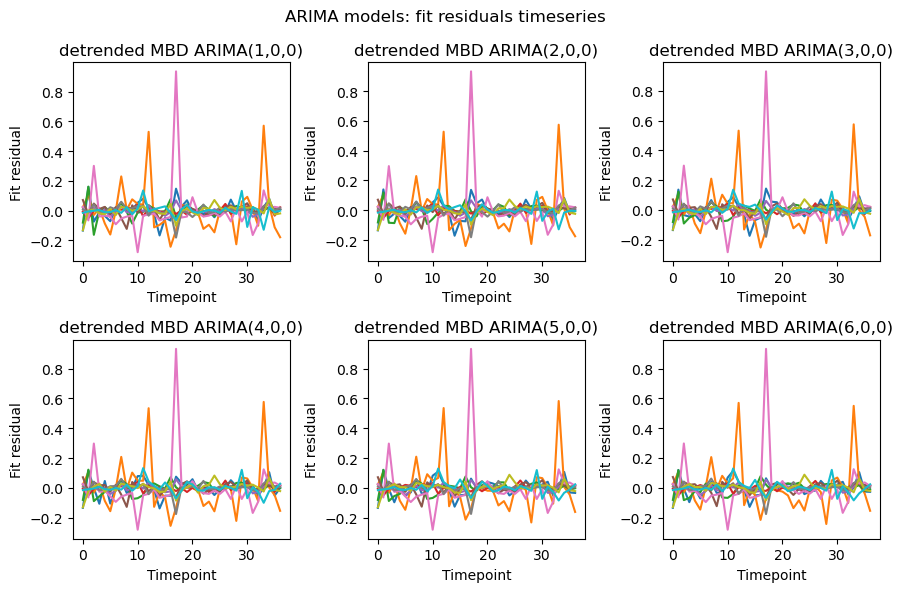

In [29]:
fig, ax = plt.subplots(len(plot_rows), len(plot_cols), figsize=(len(plot_cols) * plot_dim, len(plot_rows) * plot_dim))

for (model_string, fitted_model), subplot in zip(fitted_models.items(), product(plot_rows, plot_cols)):

    for i in range(num_samples):
        residuals = pd.DataFrame(fitted_models[model_string][i].resid)
        residuals.plot(legend=False, ax=ax[subplot])
        ax[subplot].set_xlabel(f'Timepoint')
        ax[subplot].set_ylabel(f'Fit residual')
        ax[subplot].set_title(model_string)

plt.suptitle('ARIMA models: fit residuals timeseries')
plt.tight_layout()

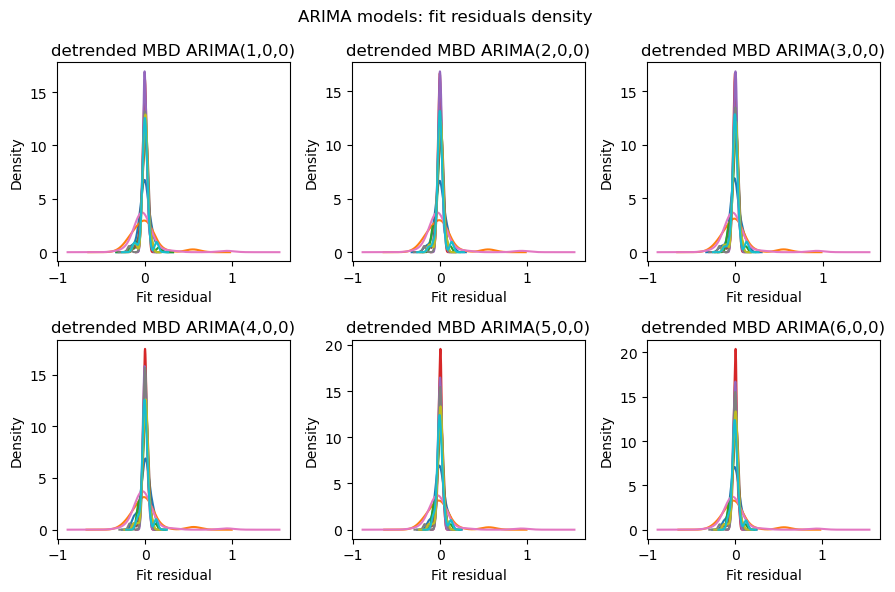

In [31]:
fig, ax = plt.subplots(len(plot_rows), len(plot_cols), figsize=(len(plot_cols) * plot_dim, len(plot_rows) * plot_dim))

for (model_string, fitted_model), subplot in zip(fitted_models.items(), product(plot_rows, plot_cols)):

    for i in range(num_samples):
        residuals = pd.DataFrame(fitted_models[model_string][i].resid)
        residuals.plot(kind='kde', legend=False, ax=ax[subplot])
        ax[subplot].set_xlabel(f'Fit residual')
        ax[subplot].set_ylabel(f'Density')
        ax[subplot].set_title(model_string)

plt.suptitle('ARIMA models: fit residuals density')
plt.tight_layout()

OK, so, what differences there are seem to be pretty subtle - this again is surprising to me. I would expect that there would be pretty significant between zero lag order and non-zero lag order.

The fit residual distributions all look pretty good to my eye, with a few exceptions. But, we already know from our preliminary bootstrapping that these models don't do anywhere near as well as the naive control, or even simple regression. I dunno, maybe we are barking up the wrong tree here.